In [1]:
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 
from glob import glob
import sklearn

from tqdm.autonotebook import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score
from pathlib import Path

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

# opensoundscape transfer learning tools
from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit, fit_classifier_on_embeddings
import os
from pathlib import Path
from pydub import AudioSegment

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_57287/3533495058.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [4]:
import os
from pathlib import Path
import pandas as pd

# Define dataset path
dataset_path = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/")
train_path = dataset_path / "train_5sec"

# Function to traverse directories and map file information to labels
def traverse_and_map(directory, label):
    audio_files = []
    labels = []
    start_times = []
    end_times = []
    
    if not directory.exists():
        print(f"Directory does not exist: {directory}")
        return pd.DataFrame()  # Return empty DataFrame if directory doesn't exist
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                # Prepend full dataset path to the file path
                audio_path = dataset_path / Path(root).relative_to(dataset_path) / file
                audio_files.append(str(audio_path))
                labels.append(label)
                start_times.append(0.0)  # Fixed start time
                end_times.append(5.0)   # Fixed end time

    # Create DataFrame for the current directory
    data = {
        "file": audio_files,
        "start_time": start_times,
        "end_time": end_times,
        "A": labels
    }
    return pd.DataFrame(data)

# Initialize a dictionary to hold DataFrames for each training size
labels_trains = {}

# Iterate over each train size folder
if train_path.exists():
    for train_size_dir in train_path.iterdir():
        if train_size_dir.is_dir():  # Ensure it's a directory
            training_size = train_size_dir.name  # Get the name of the training size directory

            # Process `pos` and `neg` subdirectories
            pos_dir = train_size_dir / "pos"
            neg_dir = train_size_dir / "neg"
            df_pos = traverse_and_map(pos_dir, 1)  # 1 for "pos" files
            df_neg = traverse_and_map(neg_dir, 0)  # 0 for "negative" files

            # Combine the DataFrames for `pos` and `neg`
            combined_df = pd.concat([df_pos, df_neg], ignore_index=True)

            # Set MultiIndex with 'file', 'start_time', and 'end_time'
            combined_df.set_index(["file", "start_time", "end_time"], inplace=True)

            # Rename the only column to "A"
            combined_df.columns = ['A']

            # Store the DataFrame in the dictionary
            labels_trains[training_size] = combined_df

            # Optionally, save each DataFrame to a CSV file
            output_path = dataset_path / f"labels_trains_{training_size}.csv"
            combined_df.to_csv(output_path)
            print(f"DataFrame saved for training size {training_size}: {output_path}")
else:
    print(f"Train path does not exist: {train_path}")

# Display the DataFrames for verification
for training_size, df in labels_trains.items():
    print(f"\nDataFrame for training size {training_size}:")
    print(df.head())


DataFrame saved for training size train_size_150: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/labels_trains_train_size_150.csv
DataFrame saved for training size train_size_25: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/labels_trains_train_size_25.csv
DataFrame saved for training size train_size_175: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/labels_trains_train_size_175.csv
DataFrame saved for training size train_size_75: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/labels_trains_train_size_75.csv
DataFrame saved for training size train_size_100: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/labels_trains_train_size_100.csv
DataFrame saved for training size train_size_50: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/labels_trains_train_size_50.csv
DataFrame saved for training size train_

Processing data for training set

In [5]:
labels_trains['train_size_150'].head(20)

,,,A
file,start_time,end_time,
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/train_5sec/train_size_150/pos/t-11844438_154.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/train_5sec/train_size_150/pos/t-11844438_168.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/train_5sec/train_size_150/pos/t-11844438_430.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/train_5sec/train_size_150/pos/t-11844438_90.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/train_5sec/train_size_150/pos/t-11844438_356.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/train_5sec/train_size_150/pos/t-11844438_342.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/train_5sec/train_size_150/pos/t-11844438_395.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/train_5sec/train_size_150/pos/t-11844438_381.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/train_5sec/train_size_150/pos/t-11844438_47.wav,0.0,5.0,1


Prepare audio Data

Step 1: Train shallow classifier on Perch embeddings

In [6]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


Step 2: Generate embeddings on the training and validation data

Training size 25

In [7]:
emb_train_25 = model.embed(labels_trains['train_size_25'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/2 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [8]:
csv_path = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/test_5sec/test_dataset_5sec.csv")
audio_file_path = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/test_5sec/test_dataset_5sec.wav")
output_folder = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/test_5sec/clips")
output_csv_dir = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/test_5sec/")
output_csv = output_csv_dir / "processed_test_dataset_5sec.csv"

# Ensure the output directories exist
output_folder.mkdir(parents=True, exist_ok=True)
output_csv_dir.mkdir(parents=True, exist_ok=True)

# Read the CSV file
df_csv = pd.read_csv(csv_path)

# Determine label based on conditions
df_csv["A"] = df_csv.apply(
    lambda row: 1 if row["label"] == 1 else 0, axis=1
)

# Load the audio file
audio = AudioSegment.from_file(audio_file_path)

# Initialize lists for DataFrame creation
file_paths = []
start_times = []
end_times = []
labels = []

# Partition the audio file into 5-second clips based on CSV
for index, row in df_csv.iterrows():
    start_time = index * 5 * 1000  # in milliseconds
    end_time = start_time + 5 * 1000  # 3 seconds later

    # Extract clip
    clip = audio[start_time:end_time]

    # Save clip to the output folder
    #WT does not have unique row identifier filename column
    filename = row["sound"]
    clip_path = output_folder / filename
    clip.export(clip_path, format="wav")

    # Add details to lists
    file_paths.append(str(clip_path))
    start_times.append(0.0)  
    end_times.append(5.0)  
    labels.append(row["A"])

# Create the DataFrame
df_processed = pd.DataFrame({
    "file": file_paths,
    "start_time": start_times,
    "end_time": end_times,
    "A": labels
})
df_processed.set_index(["file", "start_time", "end_time"], inplace=True)
df_processed.columns = ['A']
# Save the DataFrame to a CSV file
df_processed.to_csv(output_csv, index=False)

print(f"Processed dataset saved to {output_csv}")
print(f"Audio clips saved to {output_folder}")
print(df_processed.head())

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_57287/1332785623.py:20: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/test_5sec/test_dataset_5sec.wav'>
  audio = AudioSegment.from_file(audio_file_path)
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_57287/1332785623.py:40: ResourceWarning: unclosed file <_io.BufferedRandom name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/test_5sec/clips/t-11844438_64.wav'>
  clip.export(clip_path, format="wav")
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_57287/1332785623.py:40: ResourceWarning: unclosed file <_io.BufferedRandom name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/test_5sec/clips/t-11844438_95.wav'>
  clip.export(clip_path, format="wav")
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_57287/1332785623.py:40: ResourceWarning: unclosed fil

Processed dataset saved to /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/test_5sec/processed_test_dataset_5sec.csv
Audio clips saved to /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/field_cricket_5sec/test_5sec/clips
                                                                        A
file                                               start_time end_time   
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1


In [9]:
labels_val = df_processed

In [10]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/3 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.985 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [11]:
emb_train_25 = torch.tensor(emb_train_25, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_25.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_25 = emb_train_25.view(emb_train_25.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_25: {emb_train_25.shape}")
print(f"Reshaped emb_val: {emb_val.shape}")

Original shape of emb_train: torch.Size([50, 512])
Reshaped emb_train_25: torch.Size([50, 1, 32, 16])
Reshaped emb_val: torch.Size([90, 1, 32, 16])


In [12]:
import torch.nn as nn

if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [13]:
emb_train_25 = emb_train_25.repeat(1, 3, 1, 1)  # Duplicate to 3 channels
emb_val = emb_val.repeat(1, 3, 1, 1)

In [14]:
import torch.nn as nn

model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [15]:
quick_fit(model.network, emb_train_25, labels_trains['train_size_25'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 3.830962668871507e-05, Val Loss: 1.4542628526687622
val AU ROC: 0.828
val MAP: 0.828
Epoch 200/1000, Loss: 2.664650855876971e-05, Val Loss: 1.4782123565673828
val AU ROC: 0.834
val MAP: 0.834
Epoch 300/1000, Loss: 2.0251487512723543e-05, Val Loss: 1.4974730014801025
val AU ROC: 0.836
val MAP: 0.836
Epoch 400/1000, Loss: 1.6093421436380595e-05, Val Loss: 1.5164055824279785
val AU ROC: 0.836
val MAP: 0.836
Epoch 500/1000, Loss: 1.3163077710487414e-05, Val Loss: 1.5325607061386108
val AU ROC: 0.840
val MAP: 0.840
Epoch 600/1000, Loss: 1.1045744031434879e-05, Val Loss: 1.5481202602386475
val AU ROC: 0.840
val MAP: 0.840
Epoch 700/1000, Loss: 9.424967174709309e-06, Val Loss: 1.5645326375961304
val AU ROC: 0.843
val MAP: 0.843
Epoch 800/1000, Loss: 8.162513040588237e-06, Val Loss: 1.5793544054031372
val AU ROC: 0.844
val MAP: 0.844
Epoch 900/1000, Loss: 7.053300123516237e-06, Val Loss: 1.5933283567428589
val AU ROC: 0.843
val MAP: 0.843
Epoch 1000/1000, Loss: 6.16068882

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_57287/1842857064.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


0.8508641975308642

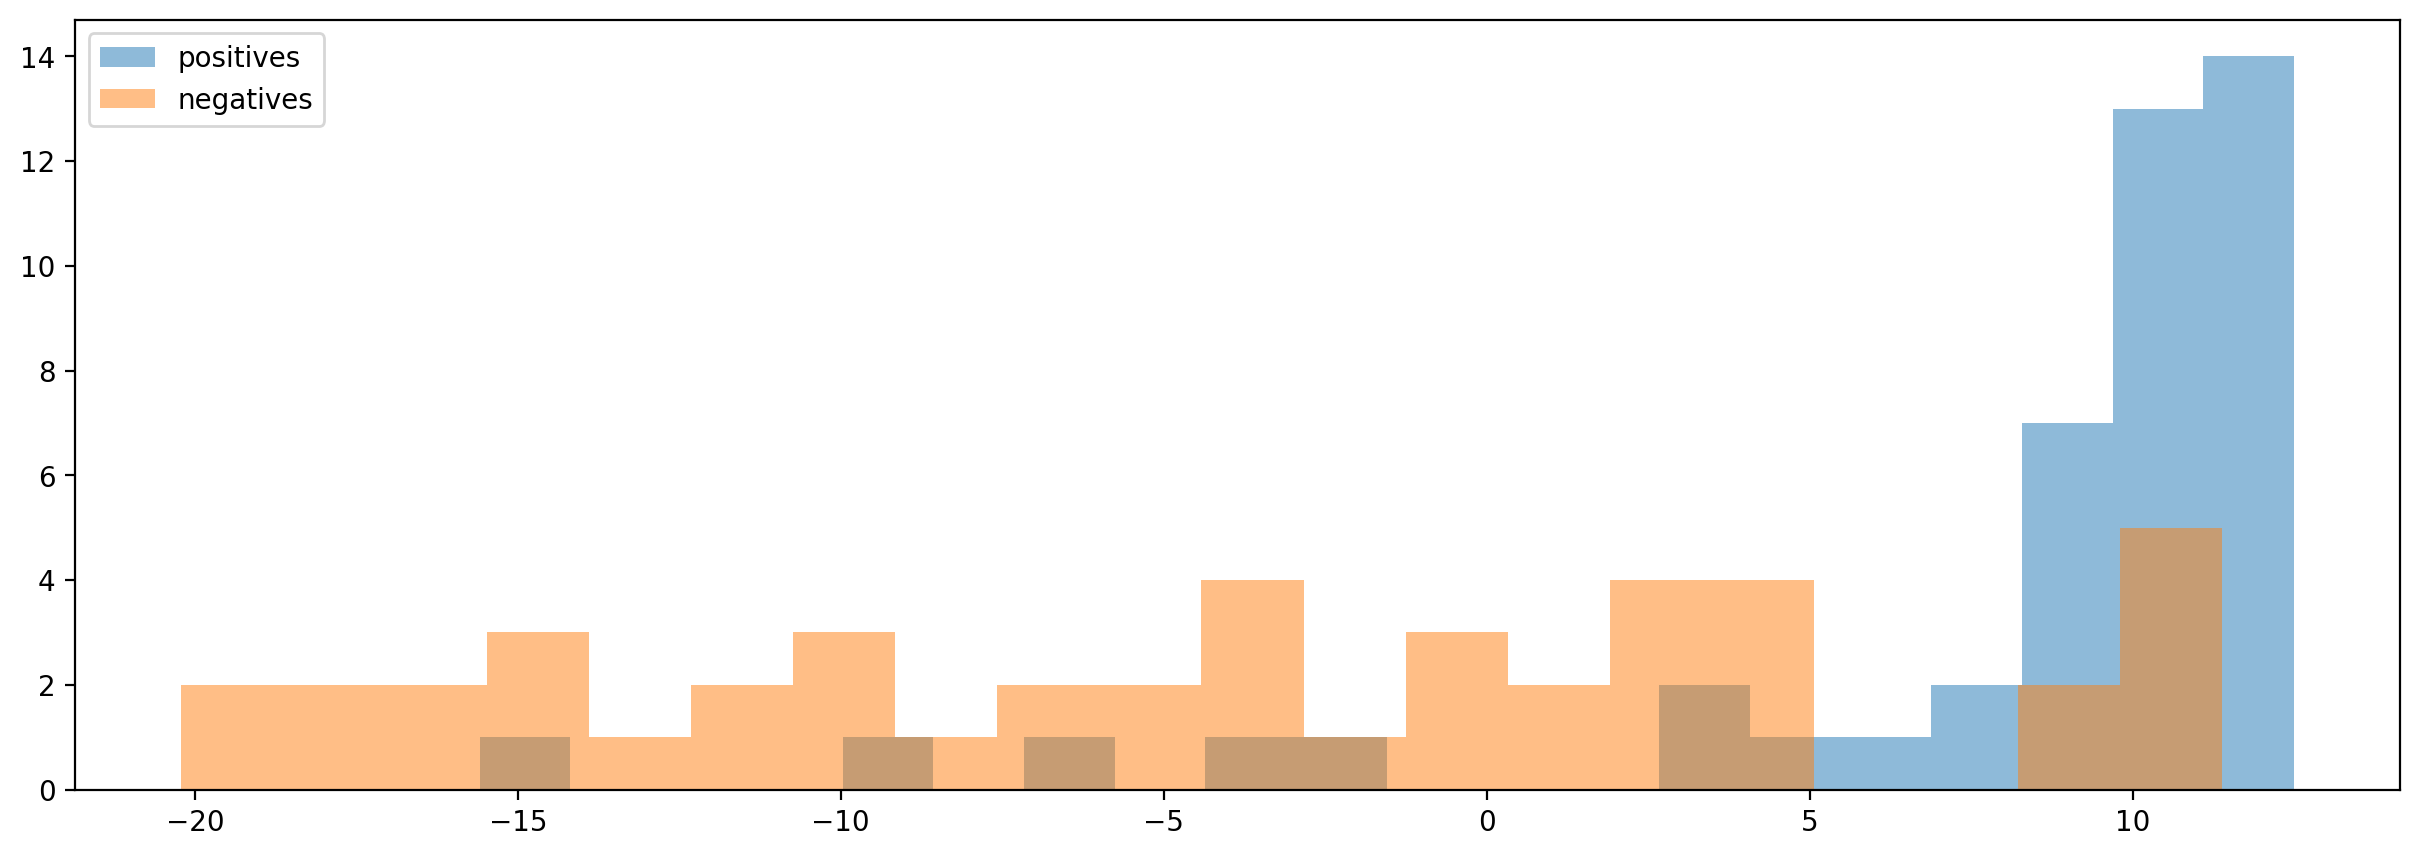

In [16]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_25 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_25

Training size 50

In [17]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [18]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/3 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.985 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [19]:
emb_train_50 = model.embed(labels_trains['train_size_50'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [20]:
emb_train_50 = torch.tensor(emb_train_50, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_50.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_50 = emb_train_50.view(emb_train_50.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_50: {emb_train_50.shape}")

Original shape of emb_train: torch.Size([100, 512])
Reshaped emb_train_50: torch.Size([100, 1, 32, 16])


In [21]:
import torch.nn as nn

if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [22]:
emb_train_50 = emb_train_50.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [23]:
import torch.nn as nn

model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [24]:
quick_fit(model.network, emb_train_50, labels_trains['train_size_50'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 4.1913517634384334e-05, Val Loss: 1.9345686435699463
val AU ROC: 0.803
val MAP: 0.803
Epoch 200/1000, Loss: 2.7043035515816882e-05, Val Loss: 2.0029540061950684
val AU ROC: 0.815
val MAP: 0.815
Epoch 300/1000, Loss: 1.992280886042863e-05, Val Loss: 2.056083917617798
val AU ROC: 0.810
val MAP: 0.810
Epoch 400/1000, Loss: 1.5569714378216304e-05, Val Loss: 2.1007485389709473
val AU ROC: 0.810
val MAP: 0.810
Epoch 500/1000, Loss: 1.250779223482823e-05, Val Loss: 2.142693281173706
val AU ROC: 0.809
val MAP: 0.809
Epoch 600/1000, Loss: 1.0267709512845613e-05, Val Loss: 2.18239426612854
val AU ROC: 0.808
val MAP: 0.808
Epoch 700/1000, Loss: 8.579202585679013e-06, Val Loss: 2.221896171569824
val AU ROC: 0.811
val MAP: 0.811
Epoch 800/1000, Loss: 7.341539003391517e-06, Val Loss: 2.2644948959350586
val AU ROC: 0.808
val MAP: 0.808
Epoch 900/1000, Loss: 6.3365760070155375e-06, Val Loss: 2.307993173599243
val AU ROC: 0.812
val MAP: 0.812
Epoch 1000/1000, Loss: 5.5493856052635

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_57287/2687331274.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.7965432098765433

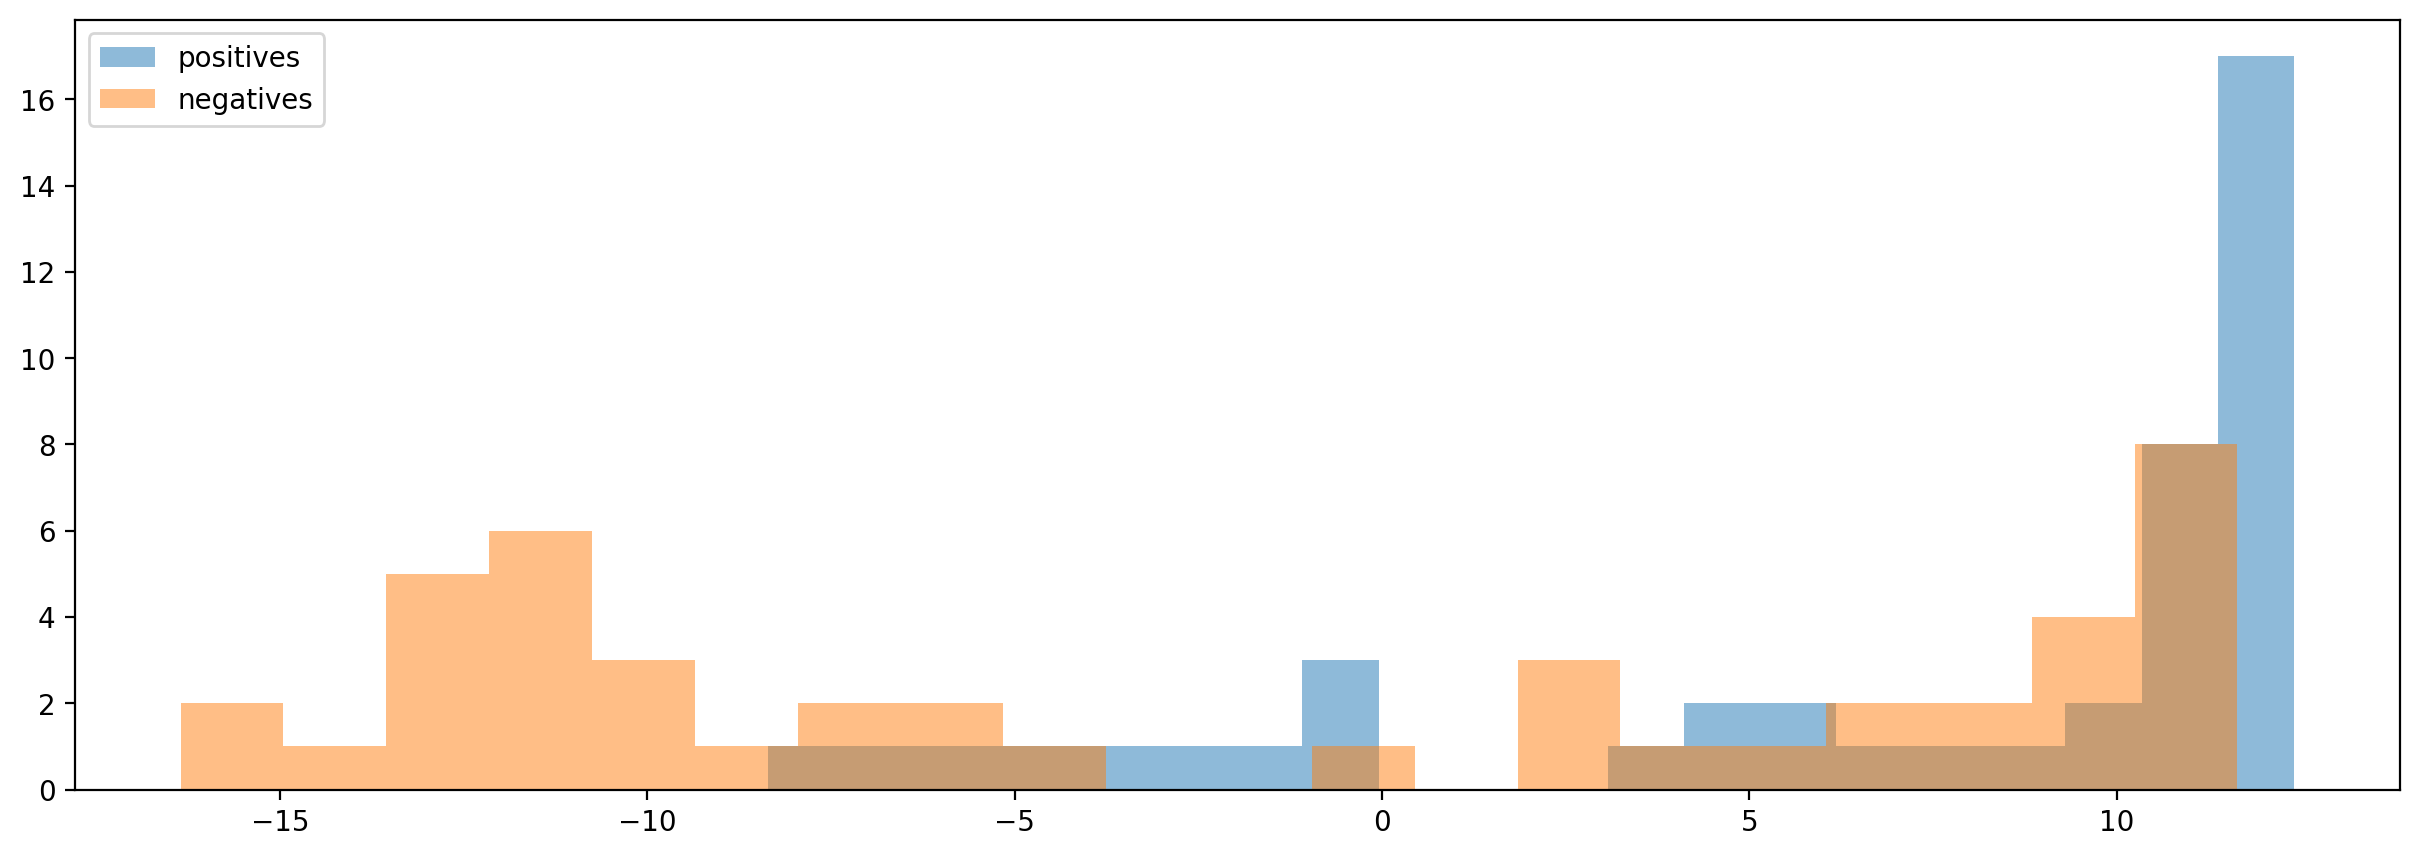

In [25]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_50 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_50

Training size 75

In [26]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [27]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/3 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.985 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [28]:
emb_train_75 = model.embed(labels_trains['train_size_75'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [29]:
emb_train_75 = torch.tensor(emb_train_75, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_75.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_75 = emb_train_75.view(emb_train_75.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_75: {emb_train_75.shape}")

Original shape of emb_train: torch.Size([150, 512])
Reshaped emb_train_75: torch.Size([150, 1, 32, 16])


In [30]:
import torch.nn as nn

if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [31]:
emb_train_75 = emb_train_75.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [32]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [33]:
quick_fit(model.network, emb_train_75, labels_trains['train_size_75'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 0.009301014244556427, Val Loss: 1.8628987073898315
val AU ROC: 0.773
val MAP: 0.773
Epoch 200/1000, Loss: 0.009277822449803352, Val Loss: 1.9182968139648438
val AU ROC: 0.777
val MAP: 0.777
Epoch 300/1000, Loss: 0.009268214926123619, Val Loss: 1.9488649368286133
val AU ROC: 0.778
val MAP: 0.778
Epoch 400/1000, Loss: 0.00926342885941267, Val Loss: 1.9342559576034546
val AU ROC: 0.769
val MAP: 0.769
Epoch 500/1000, Loss: 0.009258539415895939, Val Loss: 1.9708781242370605
val AU ROC: 0.774
val MAP: 0.774
Epoch 600/1000, Loss: 0.009255396202206612, Val Loss: 2.0006790161132812
val AU ROC: 0.780
val MAP: 0.780
Epoch 700/1000, Loss: 0.00926295481622219, Val Loss: 2.014061212539673
val AU ROC: 0.775
val MAP: 0.775
Epoch 800/1000, Loss: 0.009251742623746395, Val Loss: 2.046438455581665
val AU ROC: 0.781
val MAP: 0.781
Epoch 900/1000, Loss: 0.00925605557858944, Val Loss: 1.9492170810699463
val AU ROC: 0.777
val MAP: 0.777
Epoch 1000/1000, Loss: 0.009249680675566196, Val Lo

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_57287/4227207383.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.8074074074074074

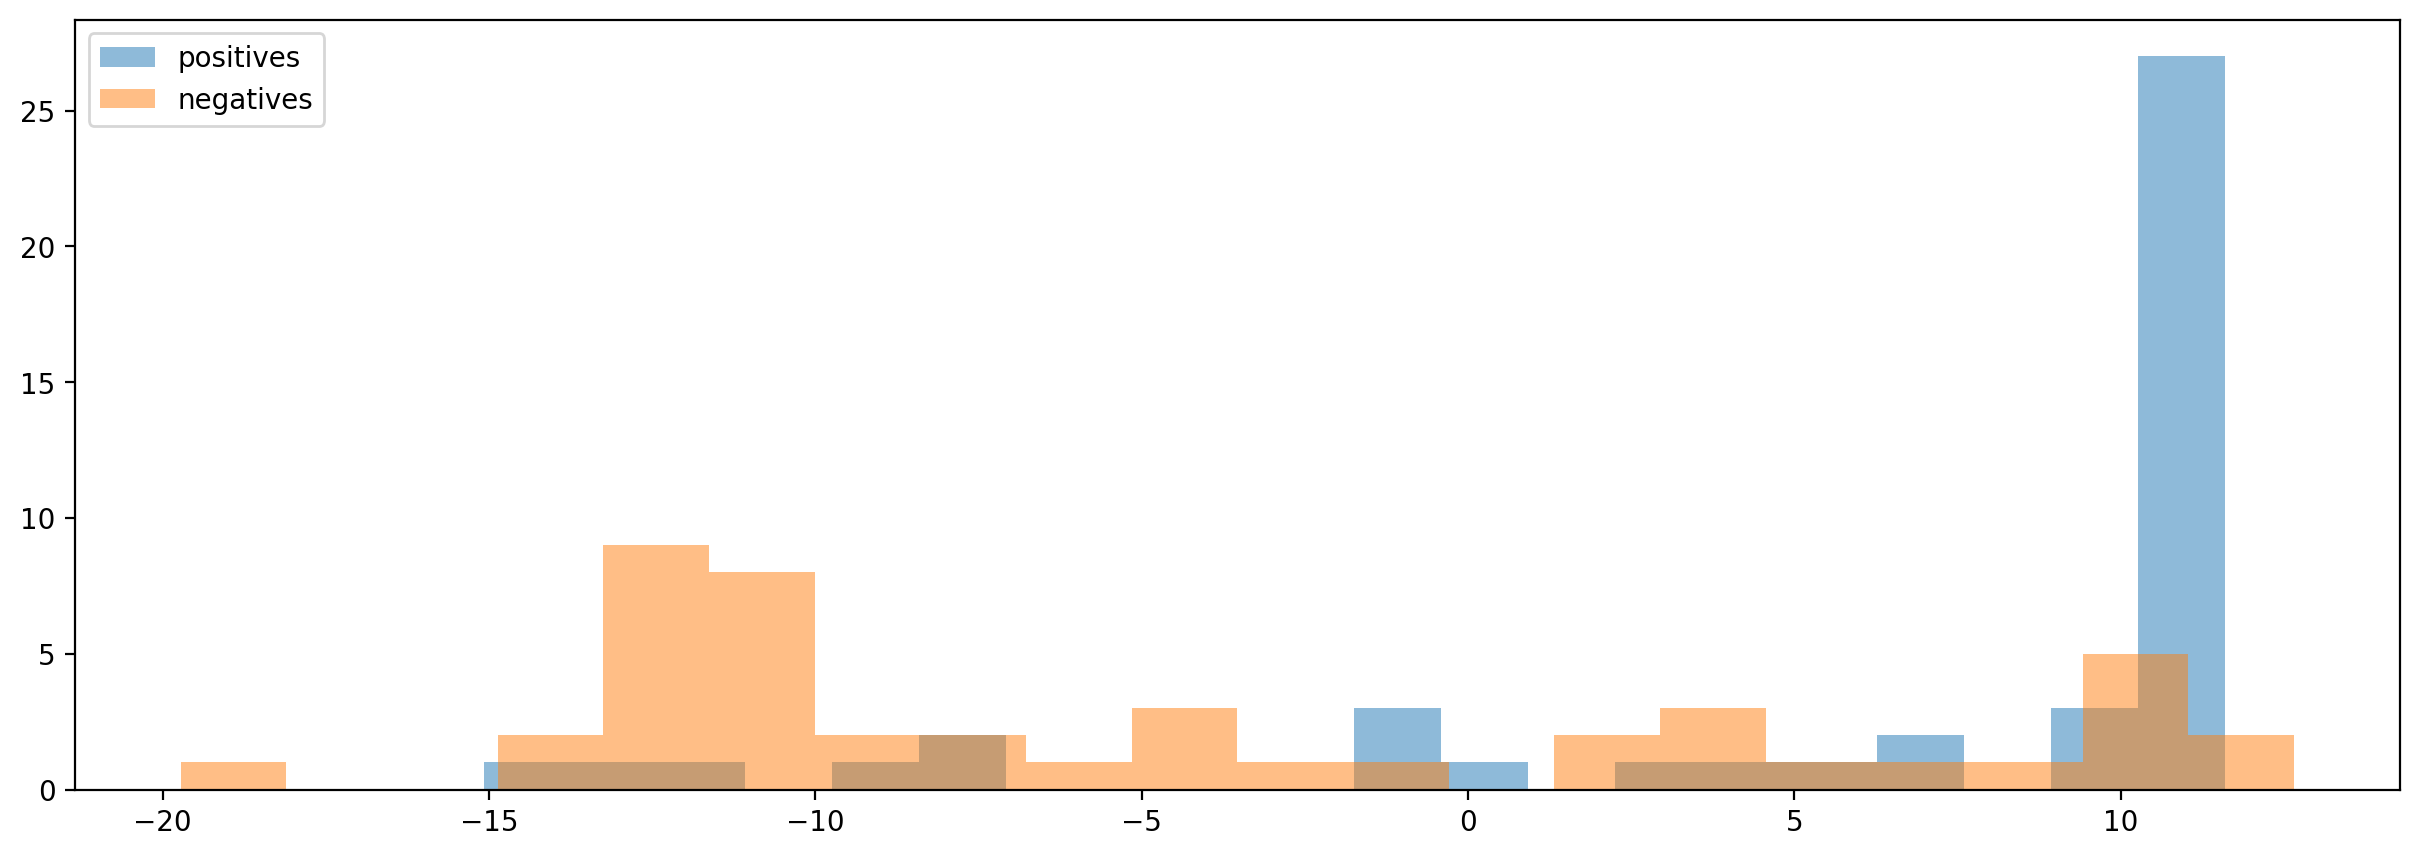

In [34]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_75 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_75

Training size 100

In [35]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [36]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/3 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.985 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [37]:
emb_train_100 = model.embed(labels_trains['train_size_100'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [38]:
emb_train_100 = torch.tensor(emb_train_100, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_100.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_100 = emb_train_100.view(emb_train_100.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)
# Verify the reshaped embeddings
print(f"Reshaped emb_train_100: {emb_train_100.shape}")

Original shape of emb_train: torch.Size([200, 512])
Reshaped emb_train_100: torch.Size([200, 1, 32, 16])


In [39]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [40]:
emb_train_100 = emb_train_100.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [41]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [42]:
quick_fit(model.network, emb_train_100, labels_trains['train_size_100'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 0.006995814852416515, Val Loss: 1.7260562181472778
val AU ROC: 0.741
val MAP: 0.741
Epoch 200/1000, Loss: 0.00696991104632616, Val Loss: 1.7958842515945435
val AU ROC: 0.738
val MAP: 0.738
Epoch 300/1000, Loss: 0.0069587635807693005, Val Loss: 1.8377959728240967
val AU ROC: 0.740
val MAP: 0.740
Epoch 400/1000, Loss: 0.006957061123102903, Val Loss: 1.8638554811477661
val AU ROC: 0.744
val MAP: 0.744
Epoch 500/1000, Loss: 0.006948000285774469, Val Loss: 1.8742130994796753
val AU ROC: 0.747
val MAP: 0.747
Epoch 600/1000, Loss: 0.006945365108549595, Val Loss: 1.8924529552459717
val AU ROC: 0.749
val MAP: 0.749
Epoch 700/1000, Loss: 0.006942753680050373, Val Loss: 1.9083331823349
val AU ROC: 0.755
val MAP: 0.755
Epoch 800/1000, Loss: 0.006941081956028938, Val Loss: 1.9237678050994873
val AU ROC: 0.756
val MAP: 0.756
Epoch 900/1000, Loss: 0.006939750164747238, Val Loss: 1.9324215650558472
val AU ROC: 0.755
val MAP: 0.755
Epoch 1000/1000, Loss: 0.00693864980712533, Val L

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_57287/1406550891.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.8158024691358023

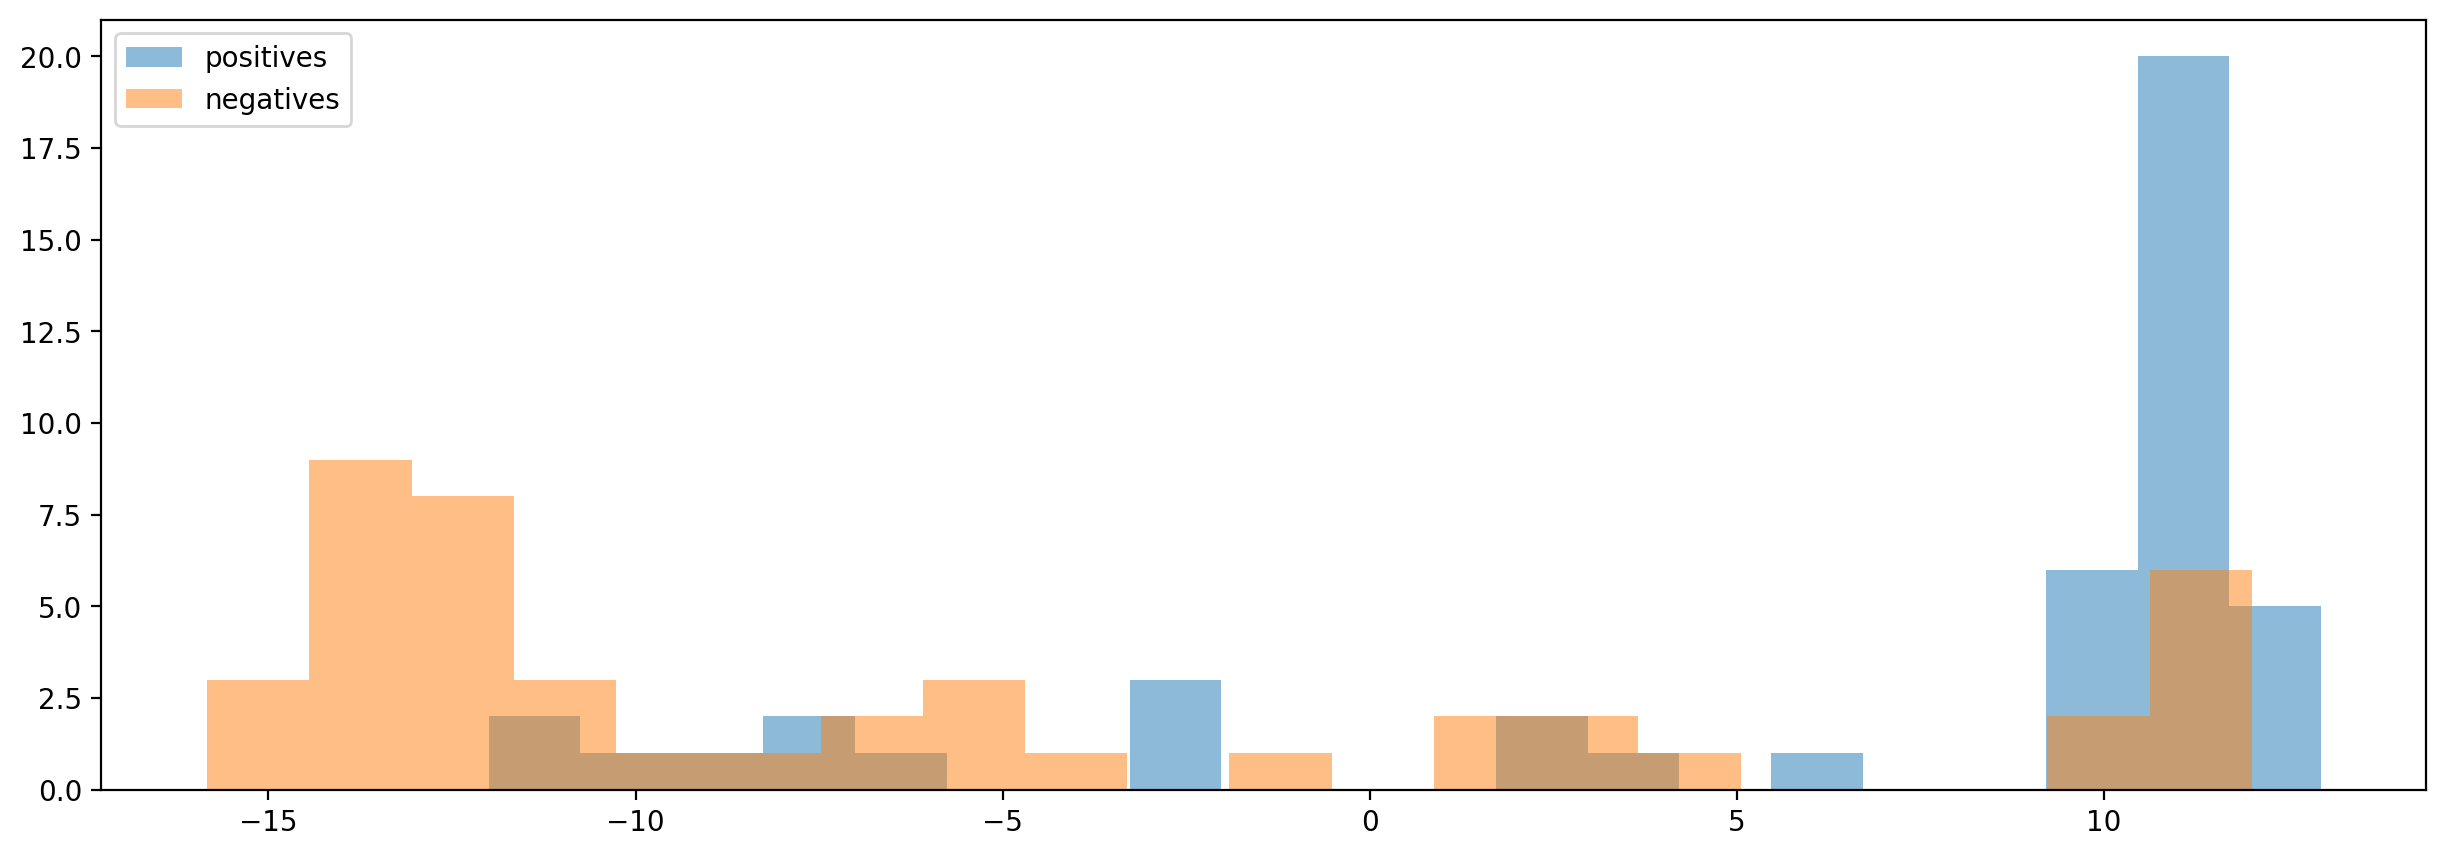

In [43]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_100 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_100

Training size 125

In [44]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [45]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/3 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.985 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [46]:
emb_train_125 = model.embed(labels_trains['train_size_125'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/8 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [47]:
emb_train_125 = torch.tensor(emb_train_125, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_125.shape}")

height, width = 32, 16  # Ensure height * width = 512
emb_train_125 = emb_train_125.view(emb_train_125.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)
# Verify the reshaped embeddings
print(f"Reshaped emb_train_100: {emb_train_125.shape}")

Original shape of emb_train: torch.Size([250, 512])
Reshaped emb_train_100: torch.Size([250, 1, 32, 16])


In [48]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [49]:
emb_train_125 = emb_train_125.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [50]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [51]:
quick_fit(model.network, emb_train_125, labels_trains['train_size_125'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 0.005606689024716616, Val Loss: 2.096297025680542
val AU ROC: 0.816
val MAP: 0.816
Epoch 200/1000, Loss: 0.0055816504172980785, Val Loss: 2.145904779434204
val AU ROC: 0.813
val MAP: 0.813
Epoch 300/1000, Loss: 0.0055713290348649025, Val Loss: 2.175513982772827
val AU ROC: 0.806
val MAP: 0.806
Epoch 400/1000, Loss: 0.005565345752984285, Val Loss: 2.2009737491607666
val AU ROC: 0.803
val MAP: 0.803
Epoch 500/1000, Loss: 0.005561414174735546, Val Loss: 2.222036600112915
val AU ROC: 0.801
val MAP: 0.801
Epoch 600/1000, Loss: 0.005558613687753677, Val Loss: 2.2472853660583496
val AU ROC: 0.803
val MAP: 0.803
Epoch 700/1000, Loss: 0.005556484684348106, Val Loss: 2.2707982063293457
val AU ROC: 0.802
val MAP: 0.802
Epoch 800/1000, Loss: 0.005554951727390289, Val Loss: 2.275947332382202
val AU ROC: 0.807
val MAP: 0.807
Epoch 900/1000, Loss: 0.005553588271141052, Val Loss: 2.301152229309082
val AU ROC: 0.803
val MAP: 0.803
Epoch 1000/1000, Loss: 0.005552513059228659, Val L

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_57287/3376882458.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.7777777777777778

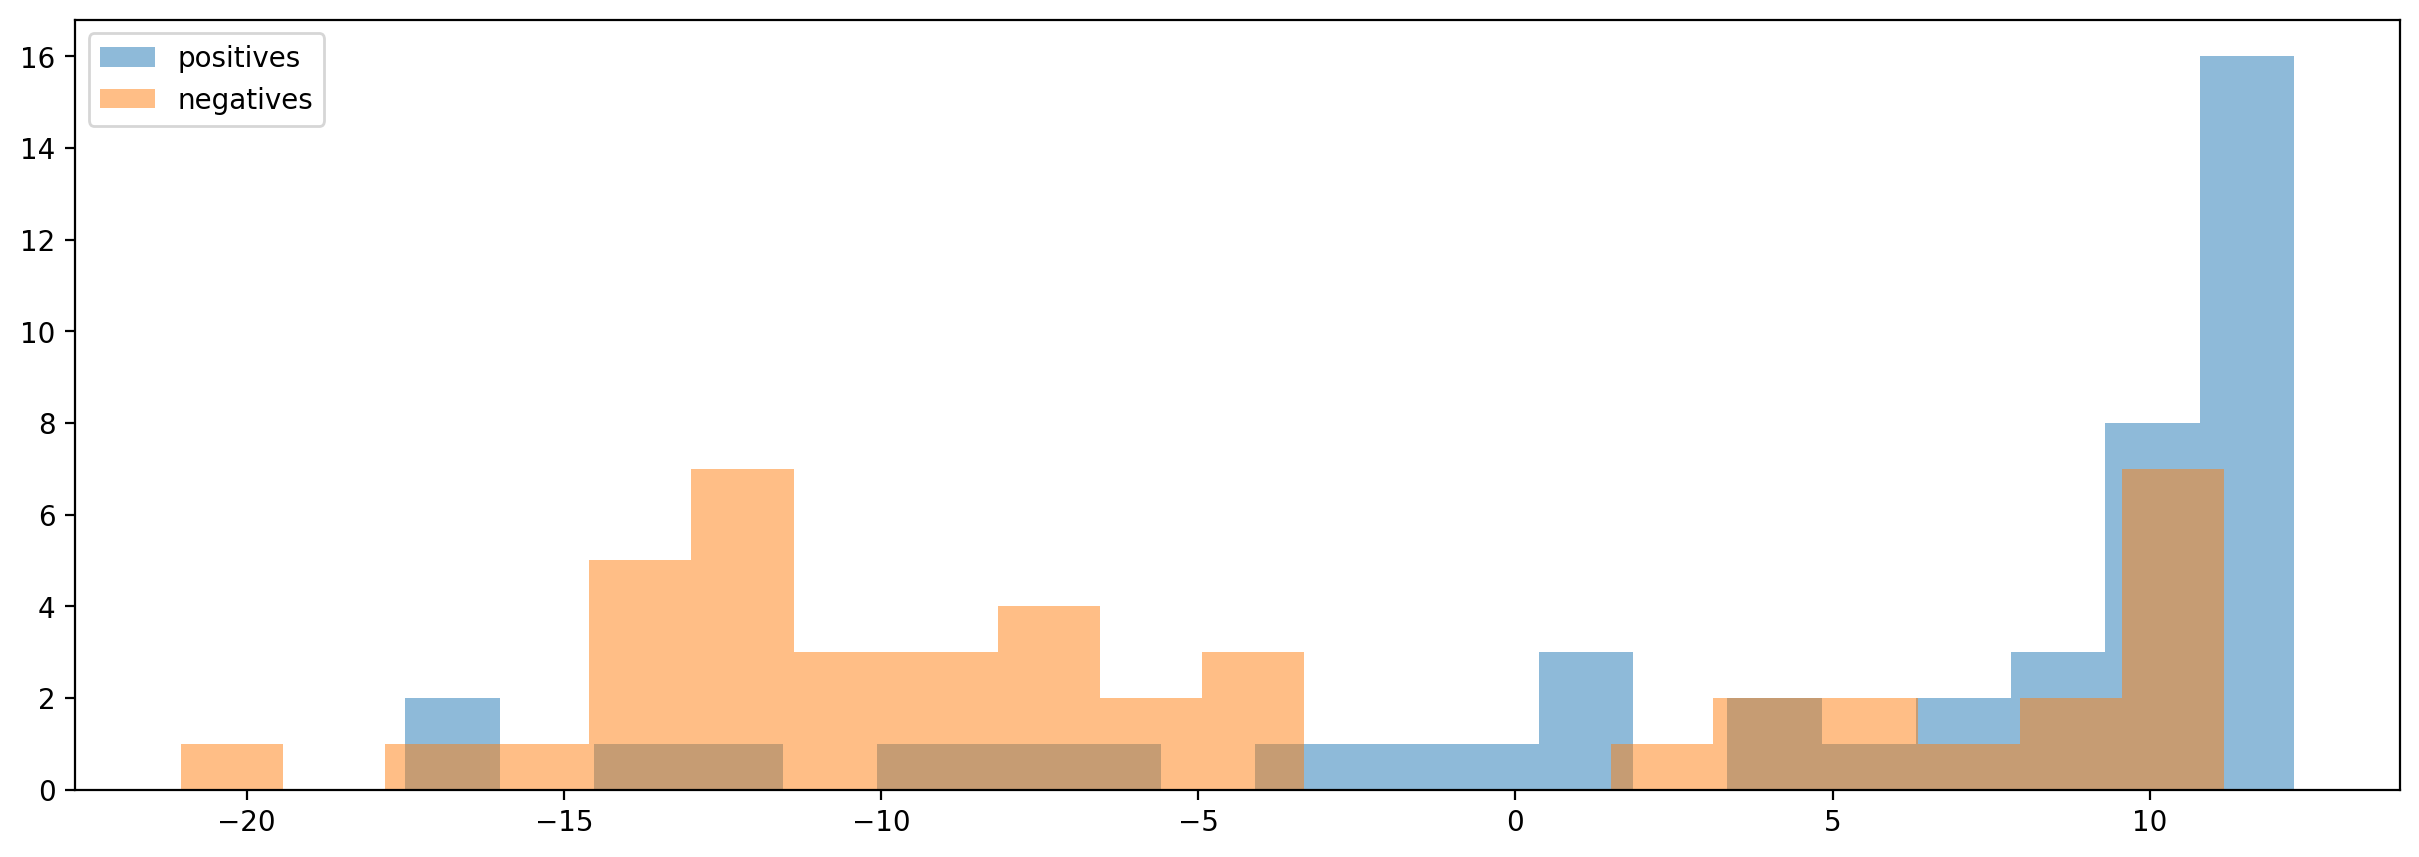

In [52]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_125 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_125

Training size 150

In [53]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [54]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/3 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.985 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [55]:
emb_train_150 = model.embed(labels_trains['train_size_150'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/10 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [56]:
emb_train_150 = torch.tensor(emb_train_150, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_150.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_150 = emb_train_150.view(emb_train_150.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_150: {emb_train_150.shape}")

Original shape of emb_train: torch.Size([300, 512])
Reshaped emb_train_150: torch.Size([300, 1, 32, 16])


In [57]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [58]:
emb_train_150 = emb_train_150.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [59]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [60]:
quick_fit(model.network, emb_train_150, labels_trains['train_size_150'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 0.004687327425926924, Val Loss: 1.6150130033493042
val AU ROC: 0.779
val MAP: 0.779
Epoch 200/1000, Loss: 0.004692417103797197, Val Loss: 1.6661540269851685
val AU ROC: 0.776
val MAP: 0.776
Epoch 300/1000, Loss: 0.0046480512246489525, Val Loss: 1.6539044380187988
val AU ROC: 0.777
val MAP: 0.777
Epoch 400/1000, Loss: 0.004642859101295471, Val Loss: 1.6631240844726562
val AU ROC: 0.789
val MAP: 0.789
Epoch 500/1000, Loss: 0.004637519828975201, Val Loss: 1.6571041345596313
val AU ROC: 0.799
val MAP: 0.799
Epoch 600/1000, Loss: 0.004634315147995949, Val Loss: 1.6686400175094604
val AU ROC: 0.802
val MAP: 0.802
Epoch 700/1000, Loss: 0.004632026422768831, Val Loss: 1.6776760816574097
val AU ROC: 0.805
val MAP: 0.805
Epoch 800/1000, Loss: 0.004630295559763908, Val Loss: 1.6871932744979858
val AU ROC: 0.806
val MAP: 0.806
Epoch 900/1000, Loss: 0.004629150964319706, Val Loss: 1.684039831161499
val AU ROC: 0.809
val MAP: 0.809
Epoch 1000/1000, Loss: 0.004627997521311045, V

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_57287/1953958238.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.8335802469135802

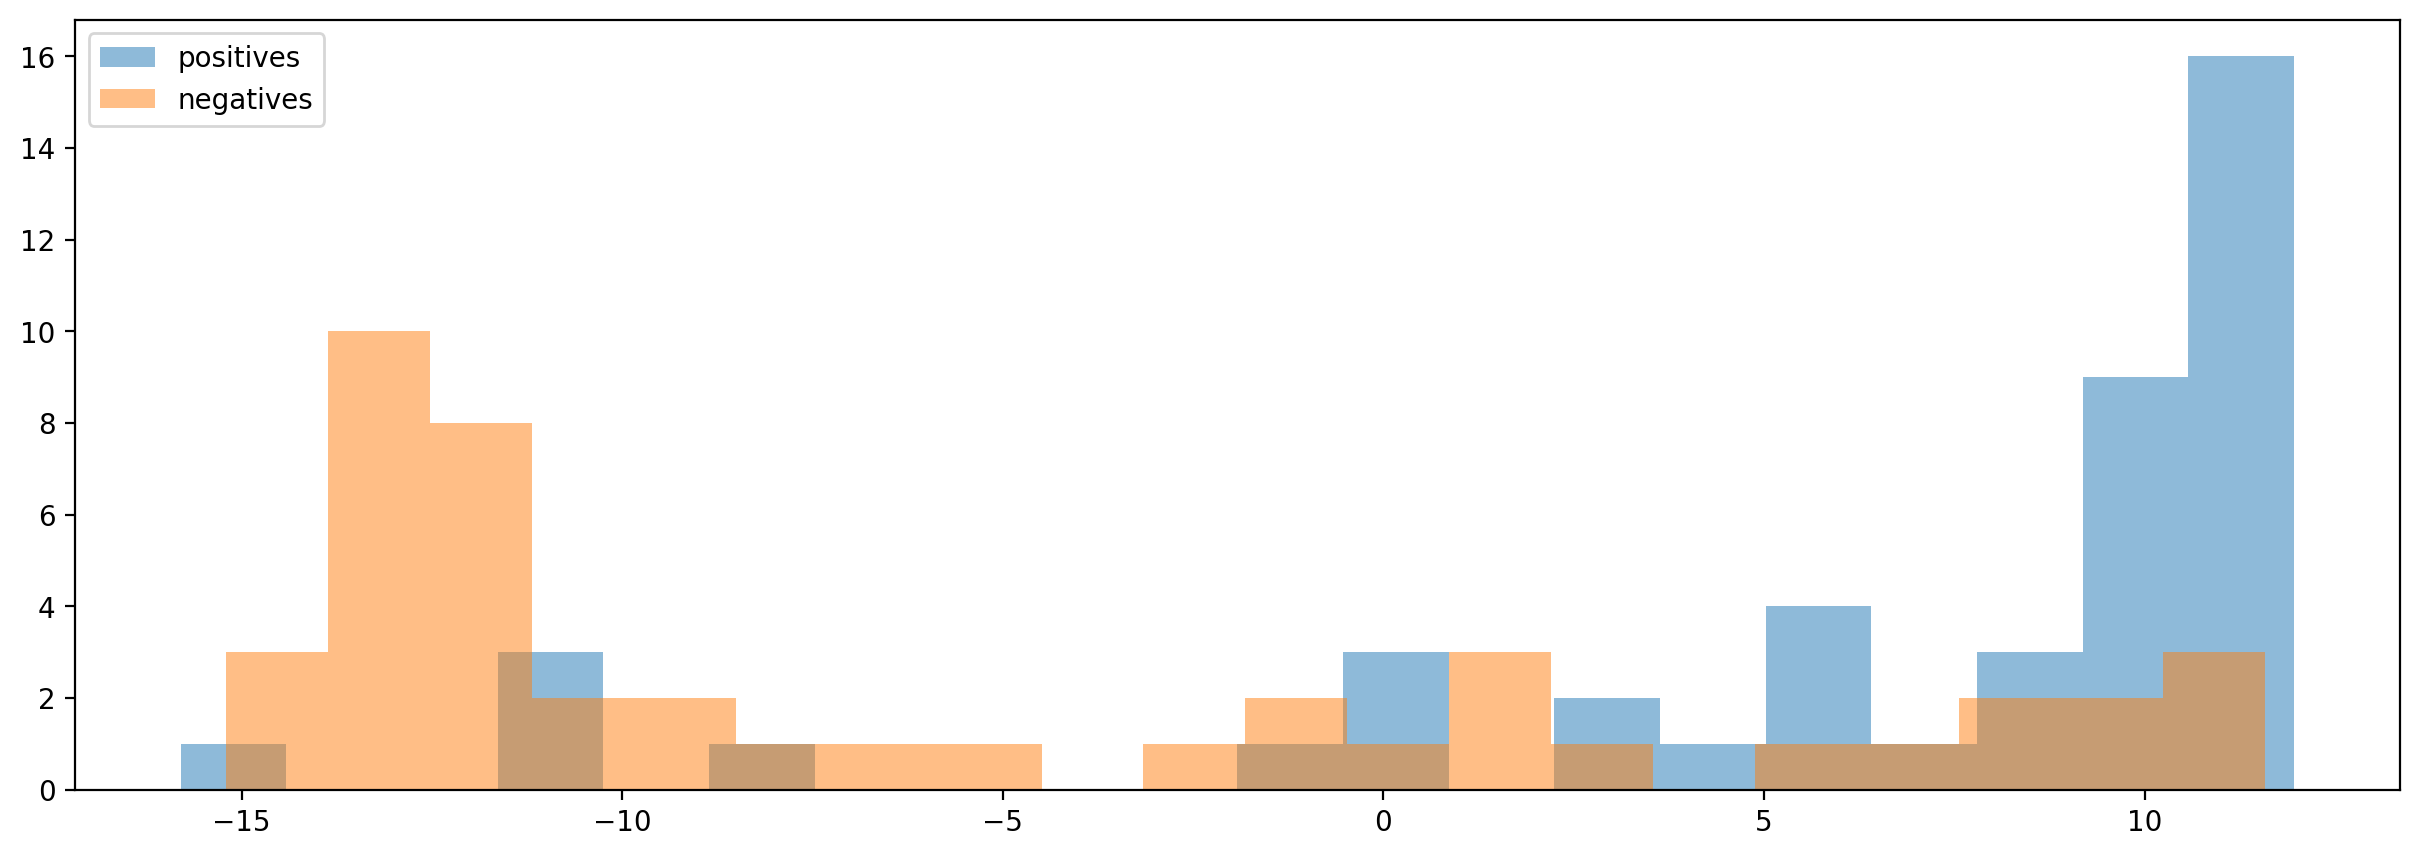

In [61]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_150 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_150

Training size 175

In [62]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [63]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/3 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.985 sec instead of 5.0 sec
  warnings.warn(error_msg)


In [64]:
emb_train_175 = model.embed(labels_trains['train_size_175'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/11 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [65]:
emb_train_175 = torch.tensor(emb_train_175, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_175.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_175 = emb_train_175.view(emb_train_175.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_175: {emb_train_175.shape}")

Original shape of emb_train: torch.Size([350, 512])
Reshaped emb_train_175: torch.Size([350, 1, 32, 16])


In [66]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [67]:
emb_train_175 = emb_train_175.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [68]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [69]:
quick_fit(model.network, emb_train_175, labels_trains['train_size_175'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 0.0040001701563596725, Val Loss: 2.466287851333618
val AU ROC: 0.694
val MAP: 0.694
Epoch 200/1000, Loss: 0.003979711327701807, Val Loss: 2.4811174869537354
val AU ROC: 0.691
val MAP: 0.691
Epoch 300/1000, Loss: 0.003974424675107002, Val Loss: 2.514707326889038
val AU ROC: 0.691
val MAP: 0.691
Epoch 400/1000, Loss: 0.003972208127379417, Val Loss: 2.5450453758239746
val AU ROC: 0.689
val MAP: 0.689
Epoch 500/1000, Loss: 0.003969843965023756, Val Loss: 2.5604875087738037
val AU ROC: 0.688
val MAP: 0.688
Epoch 600/1000, Loss: 0.003968225792050362, Val Loss: 2.580763339996338
val AU ROC: 0.692
val MAP: 0.692
Epoch 700/1000, Loss: 0.003968996927142143, Val Loss: 2.6028623580932617
val AU ROC: 0.696
val MAP: 0.696
Epoch 800/1000, Loss: 0.003966458607465029, Val Loss: 2.620582103729248
val AU ROC: 0.696
val MAP: 0.696
Epoch 900/1000, Loss: 0.003998815547674894, Val Loss: 2.638866901397705
val AU ROC: 0.697
val MAP: 0.697
Epoch 1000/1000, Loss: 0.003965562675148249, Val L

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_57287/2433222695.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.7358024691358026

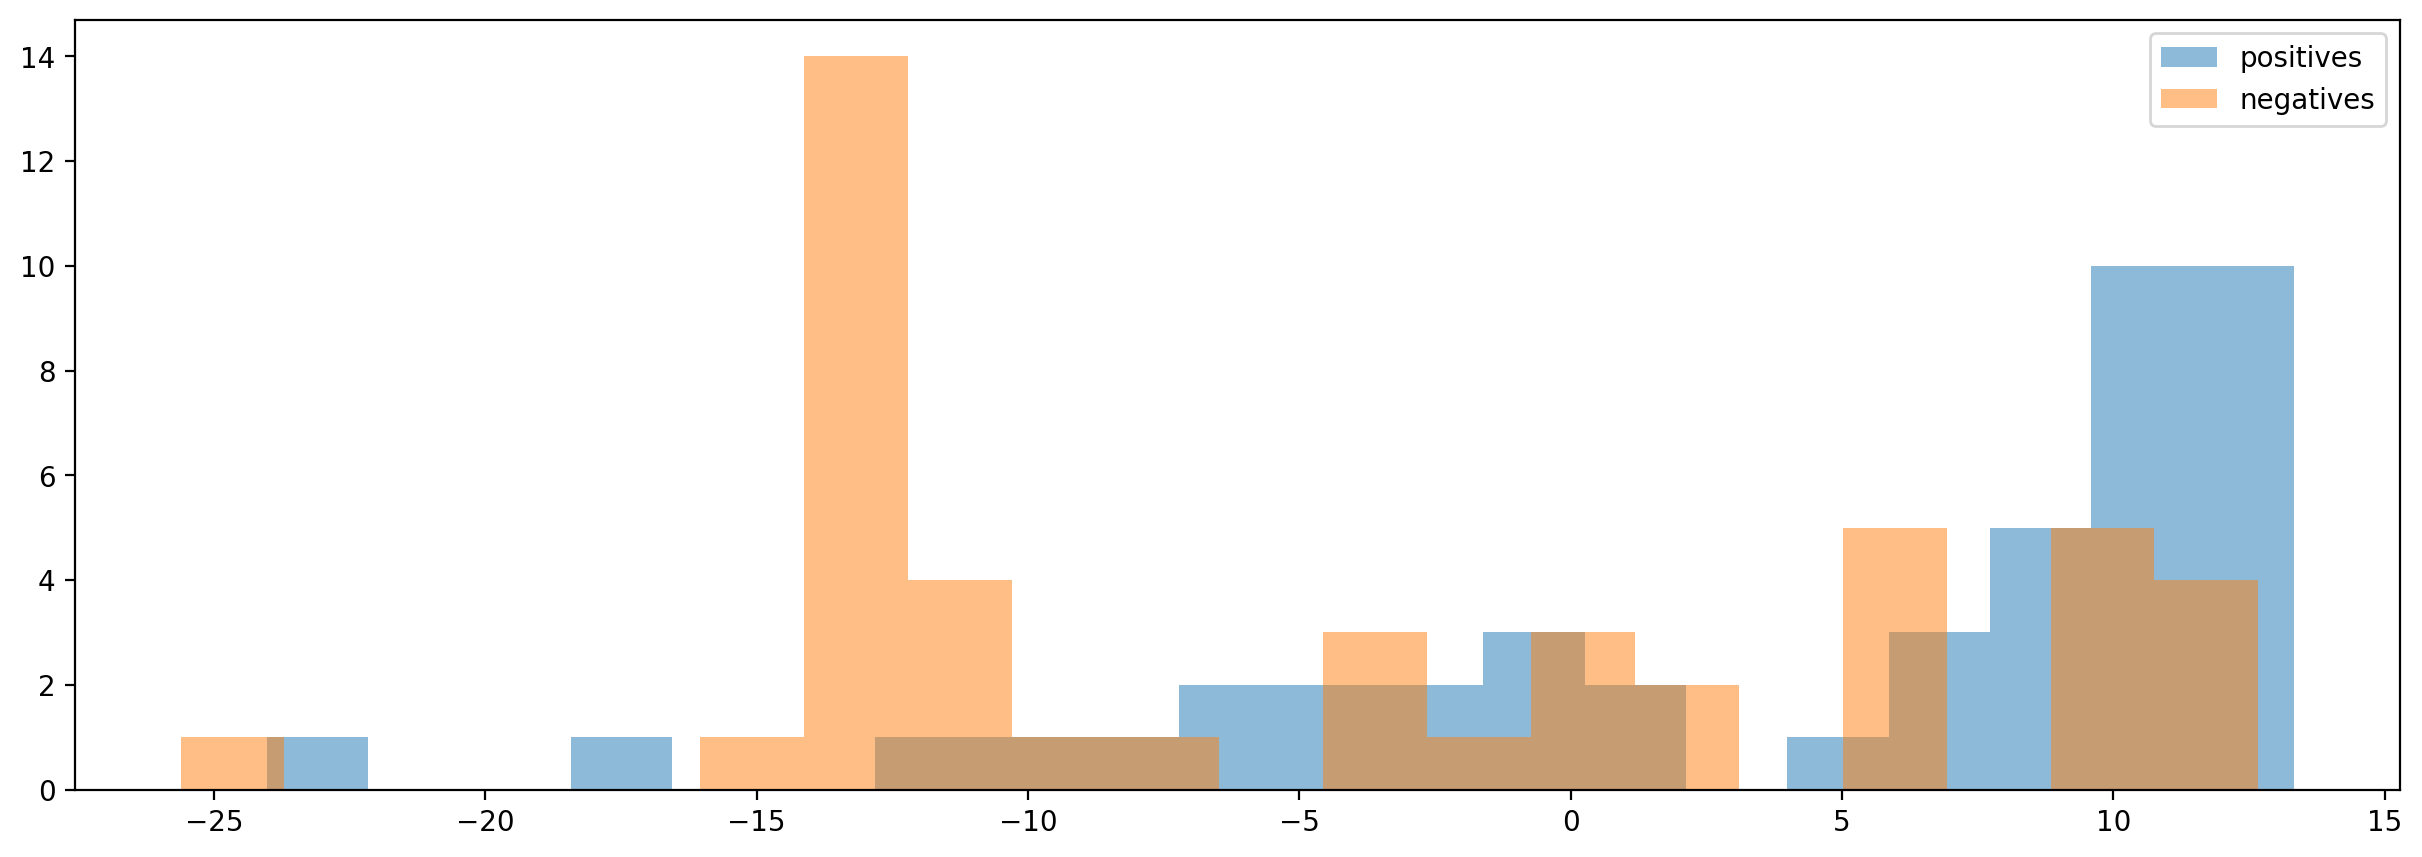

In [70]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_175 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_175

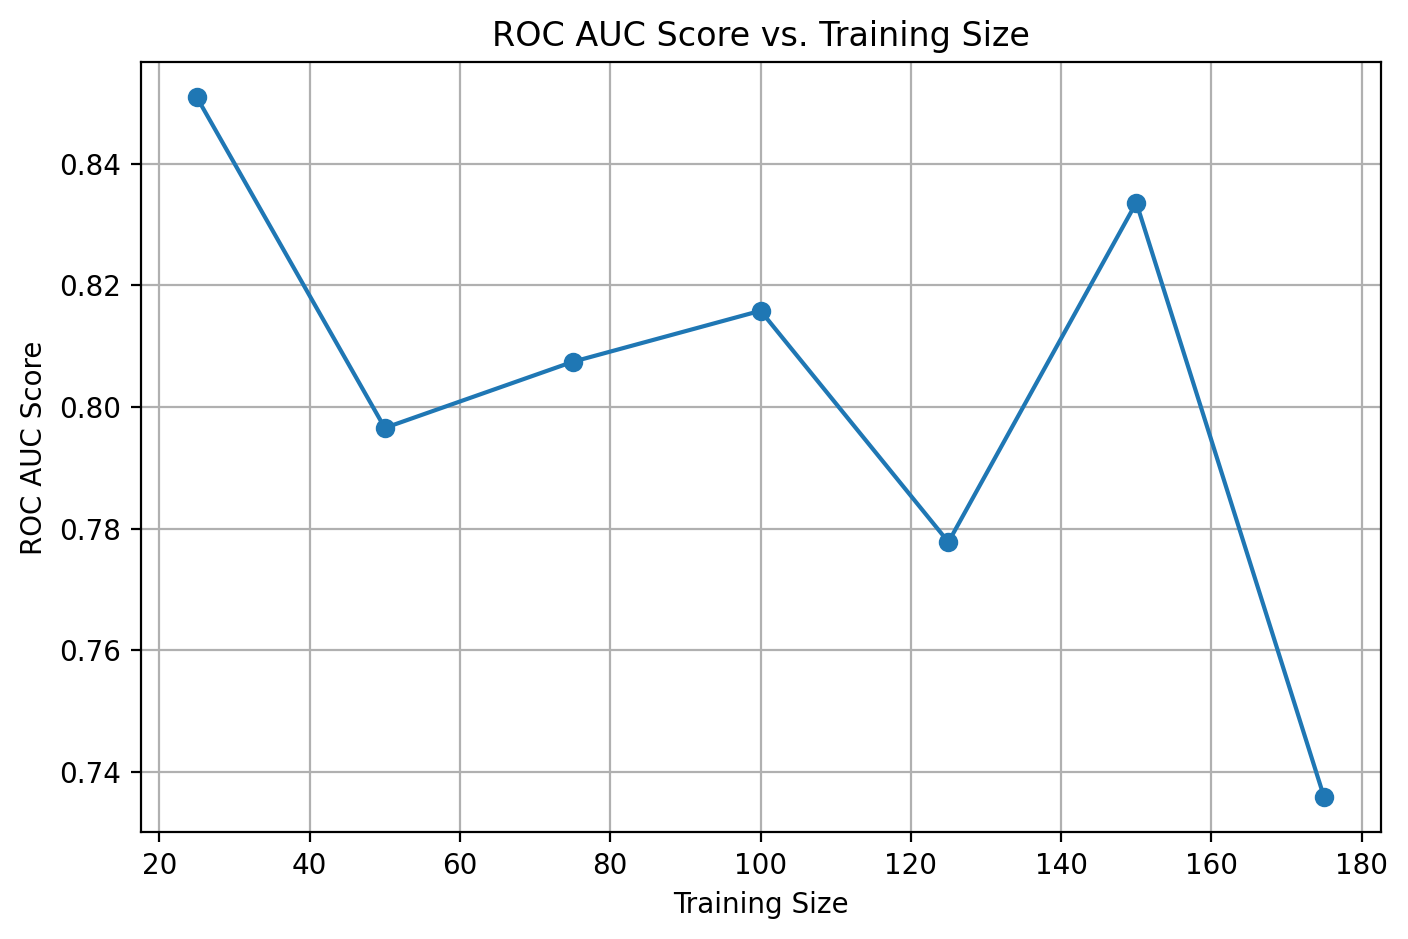

In [71]:
training_sizes = []
roc_auc_scores = []

# Iterate over training sizes and collect the scores
for size in range(25, 176, 25):
    score = eval(f"roc_auc_score_{size}")
    training_sizes.append(size)
    roc_auc_scores.append(score)

# Create a DataFrame
df = pd.DataFrame({"Training Size": training_sizes, "ROC AUC Score": roc_auc_scores})


# Plot a line plot
plt.figure(figsize=(8, 5))
plt.plot(df["Training Size"], df["ROC AUC Score"], marker='o', linestyle='-')
plt.title("ROC AUC Score vs. Training Size")
plt.xlabel("Training Size")
plt.ylabel("ROC AUC Score")
plt.grid(True)
plt.show()

In [74]:
df.head(6)

,Training Size,ROC AUC Score
0,25,0.850864
1,50,0.796543
2,75,0.807407
3,100,0.815802
4,125,0.777778
5,150,0.833580
